# Introduction to Graph Convolutional Networks
This notebook introduce Graph Convolutional networks for network scientists.
It tries to give a sense of what is going on, without entering in the details of the machine learning parts.

It is mostly based on two great resources, a tutorial by Thomas Kipf:
https://tkipf.github.io/graph-convolutional-networks/
And a tutorial of the Deep Graph Library:
https://docs.dgl.ai/index.html


In [ ]:
import networkx as nx
from sklearn.manifold import TSNE
import seaborn as sns
from matplotlib.pyplot import matshow
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

First, load and plot the zackary karate club. We color nodes according to communities found by a classic community detection algorithm.

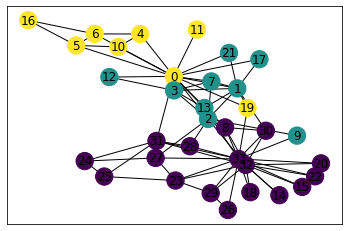

In [ ]:
graph = nx.karate_club_graph()

posSpring=nx.spring_layout(graph)#We memorize the positions of nodes to reuse the same later on
n= len(graph.nodes())# n: number of nodes
coms = nx.community.greedy_modularity_communities(graph) #find communities based on modularity maximization.
coms_right_format = [-1]*len(graph.nodes())
for cID,com in enumerate(coms):
  for c in com:
    coms_right_format[c]=cID

nx.draw_networkx(graph,pos=posSpring,with_labels=True,node_color=coms_right_format)

The first step is to extract the adjacency matrix $A$, and to create a matrix called $\hat A=A+I$.
In network terms, it corresponds to adding a self loop to each node. We will see later on that a key element of GNC consists in taking the *average values of neighbors.* By adding a self loop, the node itself will be among those neighbors.

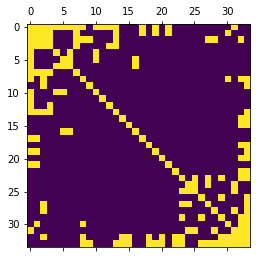

In [ ]:
A = nx.to_numpy_matrix(graph)
I = np.matrix(np.identity(n))
AplusI=A+I
matshow(AplusI)

A key idea of Graph Convolution is that each node will repeatedly compute the average of the properties of its neighbors. Let's see an example: imagine a network in which, for each node(individual), we know its age, revenue and political opinion. To each node is therefore associated a vector of dimension 3, e.g., [23(yo), 2000($), 0.8(Democrat)]. 

When a node compute the average of its neighbors value, it will end up with a new vector, still of dimension 3: [avg age, avg revenue, avg opinion].

Let's define the matrix $H$, the *feature matrix*, built by stacking all the vectors of all the nodes. Its dimensions are: $3 \times n$ in our example. More generally, $k\times n$ if there are $k$ features for each node.

The operation $\hat{A}H$ would compute the **sum** of the neighbors features. To compute a simple, unweighted average, we could use $D^{-1}A$ instead of $A$. Here is what $\hat{D}^{-1}\hat{A}$ looks like:

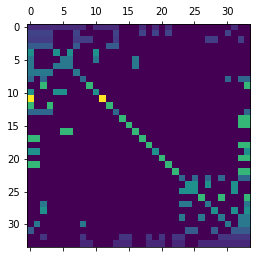

In [ ]:
degrees = list(dict(graph.degree).values())
degrees = [d+1 for d in degrees]
D = np.matrix(np.diag(degrees))
D_inverse=D**-1
A_normed = D_inverse*AplusI
matshow(A_normed)

Usually, a different normalization is used, $\hat{D}^{-\frac{1}{2}}\hat{A}\hat{D}^{-\frac{1}{2}}$. 

The operation $\hat{D}^{-\frac{1}{2}}\hat{A}\hat{D}^{-\frac{1}{2}}H$ also computes an average of neighbors' features, but this time, weighted differently according to the degree of each neighbor. One intuition about it is the following: in Twitter, a user might follow its friends, and some celebrities followed by many other users. When computing average values over all users it follows, it might be meaningful to give more weights to its friends than to the celebrities.

Note also how this normalized matrix is symmetric, unlike the previous one:

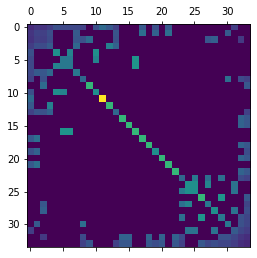

In [ ]:
D_normed=np.matrix(sp.linalg.fractional_matrix_power(D, -0.5))
A_normed2 = D_normed*AplusI*D_normed
matshow(A_normed2)

#Graph Convolution Layer
We can now introduce the *classic* Graph Convolution *Layer*. We will see later that these layers can be stacked to create a *deep neural network*. **Deep** just means *having more than one layer*. 

A GCN layer is defined as the following operation: 
$ \hat{D}^{-\frac{1}{2}}\hat{A}\hat{D}^{-\frac{1}{2}}HW$


The main ideas of the GCN layer are:


1.   For each node, compute an average of the features of neighboring nodes (as we have seen, this corresponds to $\hat{D}^{-\frac{1}{2}}\hat{A}\hat{D}^{-\frac{1}{2}}H$)
2.   For each node, combine those computed features. (how to combine is described by matrix $W$)

Step 1 is fixed once and for all, it depends only on the neighbors of the node, and on their features.

Step 2 is where the **learning** will happen. The way to combine features is not decided *a priori*, but the appropriate way to combine them will be learnt by an algorithm (backpropagation/gradient descent).

Let's define the GCN Layer

In [ ]:
def gcn_layer(A_normalized,X,W):
  """
  A_prime: A matrix describing how each node should combine the features of its neighbors (modified adjacency matrix)
  X: A matrix containing the node features in the input of this layer
  W: a matrix of weights defining how to combine node features
  """
  to_return = A_normalized*X*W
  return to_return

#GCN Forward step
Let's see what this GCN layer is doing. Applying the function described by the layer (without learning weigths) is called the *forward* step.

Since we don't know how to **learn** those weights yet, we just use random weights.

Because we do not know any feature on nodes, we use as feature matrix $H$ the Identity matrix $I$. It corresponds to a *one hot encoding*: the vector of features of node 1 is a vector full of zero, with a 1 in first position. For node 2, zeros everywhere, but in position 2. etc.

In [ ]:
def random_W(size_in,size_out):
  """
  We first define a useful function that creates a random matrix of weights (normal distribution centered on zero)
  """
  return np.matrix(np.random.normal(loc=0,scale=1,size=(size_in,size_out)))

![alt text](![alt text](https://))Testing one layer with random weights, no dimensionality reduction

Text(0.5, 1.05, 'GCN layer result')

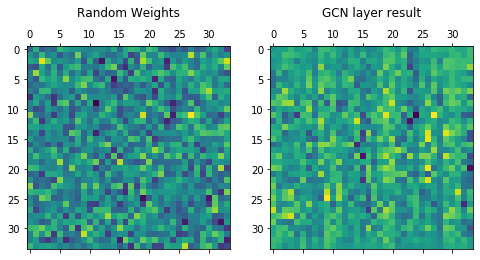

In [ ]:
W=random_W(n,n)
Hp = gcn_layer(A_normed,I,W)

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(8, 8))
axes[0].matshow(W)
axes[0].set_title("Random Weights",pad=20)
axes[1].matshow(Hp)
axes[1].set_title("GCN layer result",pad=20)

If we use a weight matrix of different size, we can redure ce number of dimensions:

Text(0.5, 1.05, 'GCN layer result')

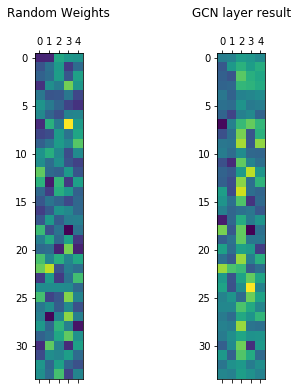

In [ ]:
W=random_W(n,5)
Hp = gcn_layer(A_normed,I,W)

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(6, 6))
axes[0].matshow(W)
axes[0].set_title("Random Weights",pad=20)
axes[1].matshow(Hp)
axes[1].set_title("GCN layer result",pad=20)

##Stacking more layers
So basically, we computed a weighted average of random weights...

Let's do something more interesting. We can stack several GCN inputs, the input of the next one being the output of the previous one. More precisely, the output of layer $l$ becomes the feature matrix $H$ of layer $l+1$.

At each layer, we will also reduce the number of features, going from n to 10, from 10 to 5, and from 5 to 2.

Text(0.5, 1.05, 'After third layer')

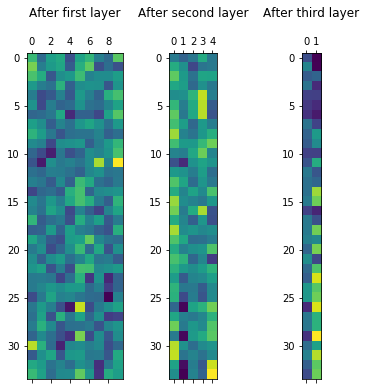

In [ ]:
H0=I
W1=random_W(n,10)
H1 = gcn_layer(A_normed2,H0,W1)
W2=random_W(10,5)
H2 = gcn_layer(A_normed2,H1,W2)
W3=random_W(5,2)
H_final = gcn_layer(A_normed2,H2,W3)

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(6, 6))
axes[0].matshow(H1)
axes[0].set_title("After first layer",pad=20)
axes[1].matshow(H2)
axes[1].set_title("After second layer",pad=20)
axes[2].matshow(H_final)
axes[2].set_title("After third layer",pad=20)

Since we now have two features per node, we can use them as coordinates, and plot the graph with nodes positions set according to our features. 

What is interesting is that, even though we just used random weights, it seems that some aspects of the structure of the network have been captured (results strongly depends on the run)

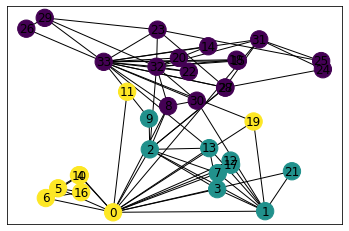

In [ ]:
nx.draw_networkx(graph,pos=np.array(H_final),with_labels=True,node_color=coms_right_format)

In [ ]:
def relu(x):
  return np.matrix(np.maximum(x, 0))

Another way to plot this: We could use obtained features (in 2D) to compute a clustering, using *k-means*

This time, node positions are the same as in the very first plot (spring layout), and the **node colors** correspond to the clusters found by k-means

Depending on the run, it can work quite well or not... but usually it seems to make sense.

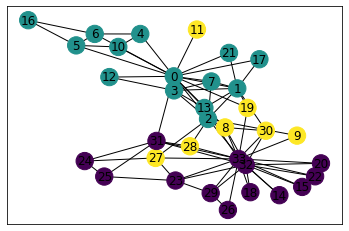

In [ ]:
from sklearn.cluster import KMeans 

clusters = KMeans(3).fit_predict(H_final.tolist())
nx.draw_networkx(graph,pos=posSpring,with_labels=True,node_color=clusters)

###To conclude this part
We know understand what is going on in a GCN layer, and when stacking layers. But of course, we are missing the most important part: learning the weights.

To do so, we will use a specialized library, DGL

# Deep Graph Library (DGL)
First, we need to install and import the Deep Graph Library, a library for deep neural networks on graphs [Deep Graph Library](https://docs.dgl.ai/index.html)

In [ ]:
!pip install dgl

And import some useful functions

In [ ]:
import dgl
import dgl.function as fn
from dgl import DGLGraph
import torch
import torch.nn as nn
import torch.nn.functional as F


DGL has its own format to describe graphs, so we transform our zackary karate club in networkx to DGL format.

In [ ]:
gDGL = dgl.DGLGraph()
gDGL.add_nodes(n)
src = [e[0] for e in graph.edges()]
dst = [e[1] for e in graph.edges()]
gDGL.add_edges(dst, src)
gDGL.add_edges(src, dst)
gDGL.add_edges(gDGL.nodes(), gDGL.nodes())

DGL being a library dedicated to Graph Convolutional Networks, the classic Graph Convolution layer is already implemented in it. Lets import it.

In [ ]:
from dgl.nn.pytorch.conv import GraphConv

We then define our *Deep Graph Convolution* by stacking layers. We reproduce the exact same one as before, i.e., 3 layers, with respectively 10, 5 and 2 as output dimensions.

With DGL, you must do that by creating your own instance of the *nn.module* class. It must implement two functions: \__init__, in which the layers are defined, and *forward*, which describes how the order of the layers. (i.e.,How to do the forward step).

In [ ]:

# We define a custom class, which correspond to a "template" called nn.Module in the DGL library.
class GCN_3layers(nn.Module):
    def __init__(self, in_feats, num_classes):
        super(GCN_2layers, self).__init__()
        #we create the two layers of "normal" DGL graph convolution
        self.gcn1 = GraphConv(in_feats, 10)
        self.gcn2 = GraphConv(10, 5)
        self.gcn2 = GraphConv(5, num_classes)

    #This function, that will be called automatically afterwards, defines what a "forward" step means for this GCN.
    #It corresponds to what we have coded in previous examples.
    #Note the relu operation in the middle. It is an activation function, whose goal is to introduce some non-linearity. 
    #Check for instance https://en.wikipedia.org/wiki/Activation_function if you want to know more
    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        h = torch.relu(h)
        h = self.gcn3(g, h)
        return h

net = GCN_3layers(n, 5, 2)


Note: DGL being a *Neural Network* library, it is based on specialized library called torch. We must use torch functions instead of similar numpy functions to create vectors and matrices.

In [ ]:
inputs = torch.eye(n) #as usual, features are "one hot encoding" of nodes, the identity matrix
#We define some "true labels", but only for two nodes, corresponding to the 2 instructors of the karate club.
labeled_nodes = torch.tensor([0, 33]) #the two instructors are nodes 0 and 33
labels = torch.tensor([0, 1])  # their labels are different
labels

In [ ]:
#we define an optimizer, that will be used to fit the weights (matrix W), see usage below.
#Note that the optimizer is provided net's parameters (our GCN parameters).
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
memory = [] #a list just to store values at every step

#We do 30 steps of optimization of the weights
for epoch in range(60):
    #We do a "forward" step, that corresponds to what we were doing manually before
    features_after = net(gDGL, inputs)

    # we save the "features" obtained for visualization later
    memory.append(features_after.detach())

    #We compute the "loss" of our model. This is what supervised machine learning usually do: we compute a "score" (loss) of how good our prediction is.
    #To check why softmax, why log-likelihood, see for instance https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/
    logp = F.log_softmax(features_after, 1)
    loss = F.nll_loss(logp[labeled_nodes], labels) #Note: we compute the loss only for labeled nodes !

    #Here, that is where the learning happens: we compute the derivatives in order to know in which direction (increase/decrease) we should modify the weights in order to improve our prediction
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.6655
Epoch 1 | Loss: 0.6520
Epoch 2 | Loss: 0.6392
Epoch 3 | Loss: 0.6258
Epoch 4 | Loss: 0.6110
Epoch 5 | Loss: 0.5943
Epoch 6 | Loss: 0.5762
Epoch 7 | Loss: 0.5561
Epoch 8 | Loss: 0.5342
Epoch 9 | Loss: 0.5100
Epoch 10 | Loss: 0.4853
Epoch 11 | Loss: 0.4602
Epoch 12 | Loss: 0.4350
Epoch 13 | Loss: 0.4096
Epoch 14 | Loss: 0.3844
Epoch 15 | Loss: 0.3597
Epoch 16 | Loss: 0.3355
Epoch 17 | Loss: 0.3121
Epoch 18 | Loss: 0.2896
Epoch 19 | Loss: 0.2680
Epoch 20 | Loss: 0.2474
Epoch 21 | Loss: 0.2278
Epoch 22 | Loss: 0.2094
Epoch 23 | Loss: 0.1922
Epoch 24 | Loss: 0.1760
Epoch 25 | Loss: 0.1609
Epoch 26 | Loss: 0.1470
Epoch 27 | Loss: 0.1340
Epoch 28 | Loss: 0.1222
Epoch 29 | Loss: 0.1113
Epoch 30 | Loss: 0.1013
Epoch 31 | Loss: 0.0923
Epoch 32 | Loss: 0.0841
Epoch 33 | Loss: 0.0767
Epoch 34 | Loss: 0.0700
Epoch 35 | Loss: 0.0639
Epoch 36 | Loss: 0.0585
Epoch 37 | Loss: 0.0536
Epoch 38 | Loss: 0.0492
Epoch 39 | Loss: 0.0453
Epoch 40 | Loss: 0.0417
Epoch 41 | Loss: 0.0385
Ep

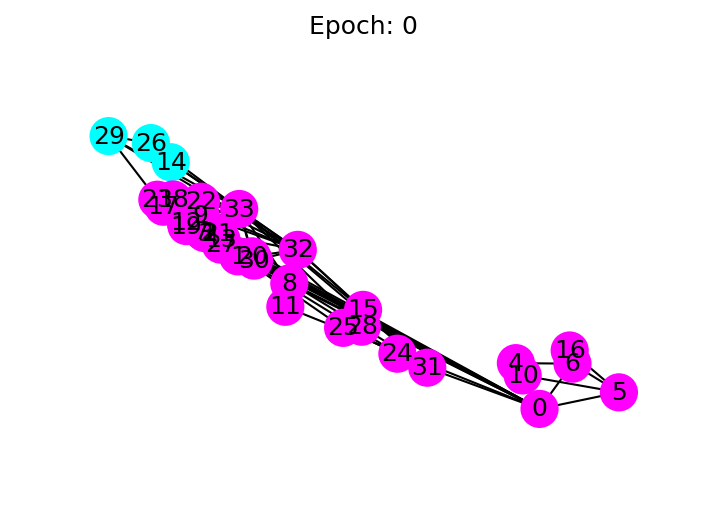

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML, Image
import matplotlib.pyplot as plt

posSpring = nx.kamada_kawai_layout(graph)
def draw_step(i):
    features = [float(x[0]) for x in memory[i]]

    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(graph, pos=posSpring, node_color=features,
            with_labels=True, node_size=300,ax=ax)

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = memory[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(graph, pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
ani = animation.FuncAnimation(fig, draw, frames=len(memory), interval=200)
#ani.save('filename.gif', writer='mencoder')
#HTML(ani.to_html5_video())
#from IPython.display import Image
#with open('filename.gif','rb') as file:
#    display(Image(file.read()))


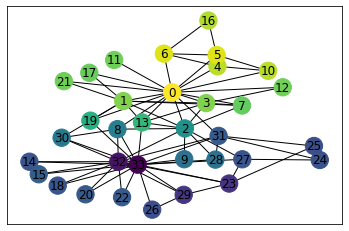

In [ ]:
features = [float(x[0]) for x in memory[-1]]
nx.draw_networkx(graph,pos=posSpring,with_labels=True,node_color=features)

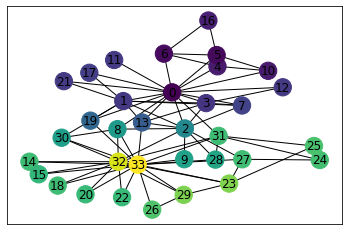

In [ ]:
features = [float(x[1]) for x in memory[-1]]
nx.draw_networkx(graph,pos=posSpring,with_labels=True,node_color=features)

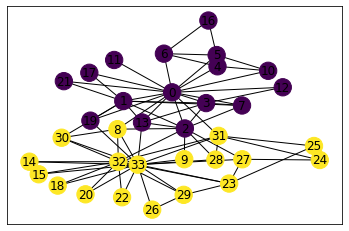

In [ ]:
feature_1 = [0 if x[0]>x[1] else 1 for x in memory[-1] ]
nx.draw_networkx(graph,pos=posSpring,with_labels=True,node_color=feature_1)

In [ ]:
list(net.parameters())

[Parameter containing:
 tensor([[-0.8550, -0.1009,  0.8491, -0.3001,  0.6751],
         [-0.1779, -0.2752,  0.6366, -0.7212,  0.3655],
         [ 0.3337,  0.2029, -0.2135,  0.1518, -0.4264],
         [-0.6549, -0.6255,  0.2534, -0.3984,  0.0485],
         [-0.8124, -0.6358,  0.6552, -0.3497,  0.3553],
         [-0.0377, -0.6859,  0.6366, -0.5049,  0.7372],
         [-0.3213, -0.5792,  0.2140, -0.2982,  0.7407],
         [-0.5982, -0.4786,  0.5139, -0.4431,  0.5601],
         [ 0.4856, -0.0328,  0.0150,  0.2603,  0.0077],
         [ 0.2772,  0.6414, -0.1255,  0.6888, -0.1086],
         [-0.0603, -0.1522,  0.2671, -0.6154,  0.4207],
         [-0.4044, -0.4391,  0.7363, -0.6063,  0.1430],
         [-0.2619, -0.5524,  0.4787, -0.5457,  0.1921],
         [-0.6200, -0.4845,  0.5172, -0.6459,  0.5061],
         [ 0.2671,  0.4662, -0.3899,  0.7692, -0.6088],
         [ 0.3443,  0.4207, -0.2828,  0.1590, -0.0053],
         [-0.6983, -0.2535,  0.3034, -0.1870,  0.2205],
         [-0.4669, -0.693

In [ ]:
list(net.parameters()[0])

TypeError: ignored

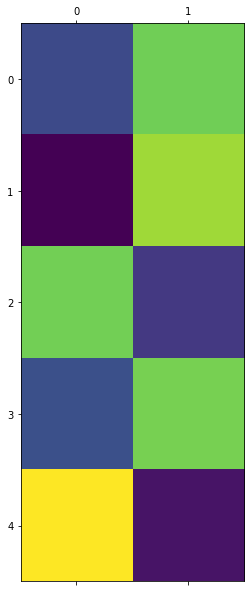

In [ ]:
for name, param in net.gcn2.named_parameters():
      if name=="weight":
        matshow(param.data.tolist())

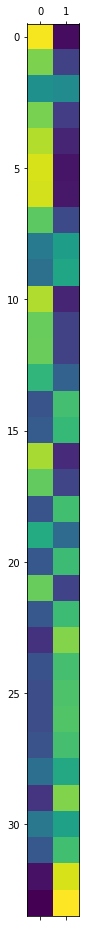

In [ ]:
matshow(memory[-1])

In [ ]:
I